### By looking at the description of the dataset from the link, the information on each field can be found.

    0. — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    1. — the id of the tweet (2087)
    2. — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    3. — the query (lyx). If there is no query, then this value is NO_QUERY.
    4. — the user that tweeted (robotickilldozr)
    5. — the text of the tweet (Lyx is cool)

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import tweepy
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import re 
from textblob import TextBlob
import sys
from matplotlib import pyplot as plt
%matplotlib inline

consumerKey = 'AkqSt3AyBtdGJKpUDO7uBvhMM'
consumerSecret = 'boKoyKZaFwSOt9PovTv2DuTuYI3BLkAghXiRVvhanbzSAzzT5H'
accessToken = '2560788740-OFNG50ry4lk9aKLK45KrO94zed9IfSjSfy66r64'
accessTokenSecret = '7q7EHRzJWPHxpC7PEXePRjZWRjhsdJoF71D38ZZTiENlK'


## setting tweeter api with the key & secrete

In [2]:
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)


In [3]:
#tweets = tweepy.Cursor(api.search, q=searchTerm).items(NoOfTerms)

In [4]:

def tweet_cleaner(text):
    tok = WordPunctTokenizer()
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    
    
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()



def SearchAndCleanTweets():
    tweets = results = api.search(
       lang="en",
       q=searchTerm + " -rt",
       count=NoOfTerms,
       result_type="recent"
    )
    

    ta = []
    for tweet in tweets:
        #print(tweet.text)
         ta.append(tweet)

    ttext = []
    #from bs4 import BeautifulSoup

    for t in ta:
        ttext.append(t._json['text'])

    df = pd.DataFrame()
    df['tweet_text'] = ttext
    
    testing = df.tweet_text[:100]
    test_result = []
    for t in testing:
        test_result.append(tweet_cleaner(t))
        
    print("Cleaning and parsing the tweets...\n")
    clean_tweet_texts = []
    for i in range(df.shape[0]):
        if( (i+1)%1000 == 0 ):
            print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))
        clean_tweet_texts.append(tweet_cleaner(df['tweet_text'][i]))

    df['clean_tweet_texts'] = clean_tweet_texts
    
    df.drop(columns=['tweet_text'], axis=1, inplace=True)
    
    df['clean_tweet_texts'] = df['clean_tweet_texts'].replace("^rt ", "", regex=True)

    df['clean_tweet_texts'] = df['clean_tweet_texts'].replace("^rt", "", regex=True)

    df['clean_tweet_texts'] = df['clean_tweet_texts'].replace("^metoo", "", regex=True)

    df['clean_tweet_texts'] = df['clean_tweet_texts'].replace("^ht", "", regex=True)

    df['clean_tweet_texts'] = df['clean_tweet_texts'].replace("^ ht", "", regex=True)
    
    
    non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)
    polarity, subjectivity, result = [], [], []
    for t in df.values:        
        analysis = TextBlob(t[0])
        pol  = round(analysis.sentiment.polarity,2)
        polarity.append(pol) 
        subjectivity.append(round(analysis.sentiment.subjectivity)) 

        if pol>0:
            result.append('Positive')
        elif pol<0 :
            result.append('Negetive')
        else:
            result.append('Neutral')

    df['polarity'] = polarity
    df['subjectivity'] = subjectivity
    df['result'] = result
    
    df.result.value_counts()

    positive, negative, neutral = df.result.value_counts()

    df = df[df['clean_tweet_texts']!=""]

    df.to_csv(searchTerm + '.csv')

    colors = ['green', 'red', 'grey']
    sizes = [positive, negative, neutral]
    labels = 'Positive', 'Negative', 'Neutral'

    print('you have searched for: ' + searchTerm)

    plt.pie(
       x=sizes,
       shadow=True,
       colors=colors,
       labels=(sizes),
       startangle=90
    );

    df1 = pd.DataFrame({'lab':labels, 'val':sizes})
    df1.plot.bar(x='lab', y='val', rot = 0);

## ask user for the search term and number of tweets to be looked at

please enter text to search: #metoo
please enter number of search result: 1000
Cleaning and parsing the tweets...

you have searched for: #metoo


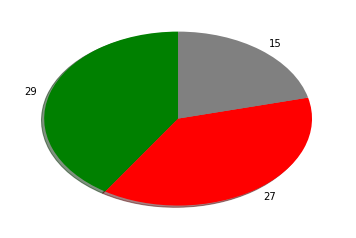

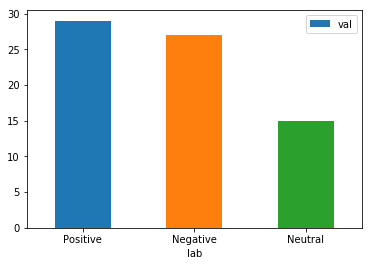

In [5]:
searchTerm = input('please enter text to search: ') #'#metoo'
NoOfTerms = input('please enter number of search result: ')#100000

SearchAndCleanTweets()